In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import numpy as np
import sklearn

In [15]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test

    return data_dict

In [17]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


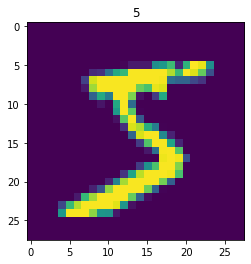

In [18]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score
from torch import Tensor


def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix=confusion_matrix(y_test, y_pred)
    precision=precision_score(y_test, y_pred,average=None)
    recall=recall_score(y_test, y_pred,average=None)

    return {'confusion matrix':conf_matrix,'accuracy':accuracy,'precision':precision,'recall':recall}

####################################################################################################

## Part 1

In [20]:
from torch import sigmoid


class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        return 1/(1+torch.exp(-x))
        
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output
                hidden = sigmoid(torch.matmul(x_batch,self.W1))
                output = sigmoid(torch.matmul(hidden,self.W2))
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden
                output_error = (torch.sub(y_batch,output))
                loss += torch.sum(output_error*output_error)
                delta_output = output_error*output*(1-output)
                delta_hidden = torch.matmul(delta_output,torch.t(self.W2))*hidden*(1-hidden)
                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                delta_W1=self.learning_rate*torch.matmul(torch.t(x_batch),delta_hidden)
                delta_W2=self.learning_rate*torch.matmul(torch.t(hidden),delta_output)
                self.W1+=delta_W1
                self.W2+=delta_W2
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels

        output = self.sigmoid(torch.matmul(self.sigmoid(torch.matmul(x, self.W1)), self.W2))
        y_pred=torch.argmax(output,dim=1)
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [21]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))

model=NN(learning_rate=0.1,n_iters=10,batch_size=20,hidden_size=40,device='cpu')
model.train(data_dict['x_train'].to(device),data_dict['y_train'].to(device),data_dict['x_val'].to(device),data_dict['y_val'].to(device))


####################################################################################################

epoch 1, loss 11713.6006, train acc 0.928, validation acc 0.935
epoch 2, loss 5219.6074, train acc 0.947, validation acc 0.951
epoch 3, loss 4269.8428, train acc 0.955, validation acc 0.957
epoch 4, loss 3739.6499, train acc 0.960, validation acc 0.960
epoch 5, loss 3383.0151, train acc 0.963, validation acc 0.961
epoch 6, loss 3120.6038, train acc 0.966, validation acc 0.963
epoch 7, loss 2910.2798, train acc 0.968, validation acc 0.964
epoch 8, loss 2736.9832, train acc 0.971, validation acc 0.963
epoch 9, loss 2589.3792, train acc 0.972, validation acc 0.964
epoch 10, loss 2460.9475, train acc 0.974, validation acc 0.964


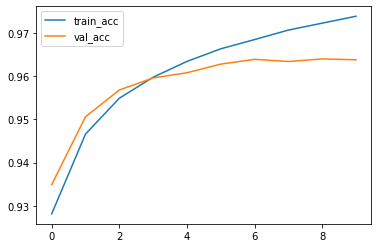

In [22]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [23]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator

evaluator(data_dict['y_test'].argmax(dim=1),model.predict(data_dict['x_test']))
####################################################################################################

{'confusion matrix': array([[ 964,    0,    1,    1,    1,    2,    5,    2,    2,    2],
        [   0, 1108,    1,    3,    1,    2,    3,    0,   17,    0],
        [   7,    1,  973,   12,    4,    3,    9,    8,   15,    0],
        [   0,    0,    4,  980,    0,   12,    1,    7,    4,    2],
        [   3,    0,    0,    0,  940,    0,   10,    3,    3,   23],
        [   6,    1,    2,   13,    0,  841,   11,    1,   13,    4],
        [   8,    2,    1,    1,    3,    5,  933,    0,    5,    0],
        [   2,    6,   16,   14,    0,    0,    0,  972,    2,   16],
        [   5,    0,    4,    8,    5,    5,    7,    3,  934,    3],
        [   6,    5,    0,    9,   10,    5,    2,    8,    5,  959]],
       dtype=int64),
 'accuracy': 0.9604,
 'precision': array([0.96303696, 0.98664292, 0.97105788, 0.9414025 , 0.97510373,
        0.96114286, 0.95107034, 0.96812749, 0.934     , 0.95044599]),
 'recall': array([0.98367347, 0.97621145, 0.94282946, 0.97029703, 0.95723014,
        

## Part 2

In [24]:
x_test=data_dict['y_test']
print(type(x_test))

<class 'torch.Tensor'>


### Model2-1

In [25]:
####################################################################################################
# enter code here to implement Model2-1
import tensorflow as tf
from tensorflow import keras
train = MNIST(root = '.', train = True, download = True)
test = MNIST(root = '.', train = False, download = True)

# data preprocessing
x_train, x_test = train.data/255, test.data/255
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
y_train = torch.nn.functional.one_hot(train.targets)
y_test = torch.nn.functional.one_hot(test.targets)
x_val=data_dict['x_val']
y_val=data_dict['y_val']

inputsize=100
modelnn=keras.Sequential([
    
keras.layers.Dense(x_test.shape[1],activation= 'sigmoid'),
keras.layers.Dense(20,activation= 'sigmoid'),
keras.layers.Dense(10)

])



#

####################################################################################################

In [26]:
####################################################################################################
# enter code here to train Model2-1
modelnn.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
              
modelnn.fit(x_train.numpy(), y_train.numpy(), epochs = 10, batch_size = 200, verbose = 1, validation_split = 0.5, validation_data=(x_val.numpy(), y_val.numpy()))



####################################################################################################

Epoch 1/10
300/300 [==============================] - 8s 25ms/step - loss: 0.0468 - accuracy: 0.7912 - val_loss: 0.0289 - val_accuracy: 0.9014
Epoch 2/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0261 - accuracy: 0.8979 - val_loss: 0.0204 - val_accuracy: 0.9223
Epoch 3/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0191 - accuracy: 0.9216 - val_loss: 0.0157 - val_accuracy: 0.9366
Epoch 4/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0153 - accuracy: 0.9351 - val_loss: 0.0128 - val_accuracy: 0.9500
Epoch 5/10
300/300 [==============================] - 5s 15ms/step - loss: 0.0129 - accuracy: 0.9458 - val_loss: 0.0109 - val_accuracy: 0.9582
Epoch 6/10
300/300 [==============================] - 4s 14ms/step - loss: 0.0112 - accuracy: 0.9536 - val_loss: 0.0094 - val_accuracy: 0.9646
Epoch 7/10
300/300 [==============================] - 4s 15ms/step - loss: 0.0099 - accuracy: 0.9602 - val_loss: 0.0085 - val_accuracy: 0.9685

In [27]:
####################################################################################################
# enter code here to evaluate Model2-1
modelnn.summary()
results = modelnn.evaluate(x_test.numpy(), y_test.numpy(), batch_size = 200)
print("test loss, test acc:", results)

####################################################################################################

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (200, 784)                615440    
                                                                 
 dense_1 (Dense)             (200, 20)                 15700     
                                                                 
 dense_2 (Dense)             (200, 10)                 210       
                                                                 
Total params: 631,350
Trainable params: 631,350
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.9678
test loss, test acc: [0.007676230743527412, 0.9678000211715698]


### Model2-2

In [28]:
####################################################################################################
# enter code here to implement Model2-2
train = MNIST(root = '.', train = True, download = True)
test = MNIST(root = '.', train = False, download = True)

# data preprocessing
x_train, x_test = train.data/255, test.data/255
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
y_train = torch.nn.functional.one_hot(train.targets)
y_test = torch.nn.functional.one_hot(test.targets)
x_val=data_dict['x_val']
y_val=data_dict['y_val']

inputsize=100
modelnn2=keras.Sequential([
    
keras.layers.Dense(x_test.shape[1],activation= 'sigmoid'),
keras.layers.Dense(20,activation= 'sigmoid'),
keras.layers.Dense(30,activation= 'sigmoid'),
keras.layers.Dense(10)

])
####################################################################################################

In [29]:
####################################################################################################
# enter code here to train Model2-2
modelnn2.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
              
modelnn2.fit(x_train.numpy(), y_train.numpy(), epochs = 10, batch_size = 200, verbose = 1, validation_split = 0.5, validation_data=(x_val.numpy(), y_val.numpy()))

####################################################################################################

Epoch 1/10
300/300 [==============================] - 7s 21ms/step - loss: 0.0686 - accuracy: 0.6347 - val_loss: 0.0447 - val_accuracy: 0.8712
Epoch 2/10
300/300 [==============================] - 6s 20ms/step - loss: 0.0338 - accuracy: 0.8959 - val_loss: 0.0214 - val_accuracy: 0.9285
Epoch 3/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0161 - accuracy: 0.9298 - val_loss: 0.0108 - val_accuracy: 0.9481
Epoch 4/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0105 - accuracy: 0.9459 - val_loss: 0.0080 - val_accuracy: 0.9623
Epoch 5/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0084 - accuracy: 0.9575 - val_loss: 0.0065 - val_accuracy: 0.9706
Epoch 6/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0071 - accuracy: 0.9643 - val_loss: 0.0057 - val_accuracy: 0.9743
Epoch 7/10
300/300 [==============================] - 5s 18ms/step - loss: 0.0062 - accuracy: 0.9705 - val_loss: 0.0049 - val_accuracy: 0.9791

In [31]:
####################################################################################################
# enter code here to evaluate Model2-2
modelnn2.summary()
results = modelnn.evaluate(x_test.numpy(), y_test.numpy(), batch_size = 200)
print("test loss, test acc:", results)

####################################################################################################

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (200, 784)                615440    
                                                                 
 dense_4 (Dense)             (200, 20)                 15700     
                                                                 
 dense_5 (Dense)             (200, 30)                 630       
                                                                 
 dense_6 (Dense)             (200, 10)                 310       
                                                                 
Total params: 632,080
Trainable params: 632,080
Non-trainable params: 0
_________________________________________________________________
50/50 [==============================] - 1s 13ms/step - loss: 0.0077 - accuracy: 0.9678
test loss, test acc: [0.007676230743527412, 0.9678000211715698]
